# Setup

## Installs
Note: You may need to restart the runtime after running this the first time and/or run this cell twice for the imports to work.

In [1]:
!pip install --upgrade lightly tsai torch torchtext>=0.11.0 dask[dataframe] pacmap

tcmalloc: large alloc 1147494400 bytes == 0x393b8000 @  0x7f0fb95d1615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e


In [2]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [3]:
import lightly
from tsai.all import *
from lightly.models.modules.heads import SimSiamPredictionHead

from skimage.transform import resize
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import QuantileTransformer
import numpy as np
import pacmap

from torchvision.transforms import Compose, ToTensor
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader

from torchvision.models import resnet18

from tempfile import NamedTemporaryFile
import os
from shutil import rmtree
import random

import dask
import dask
import dask.dataframe as dd

import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from PIL import Image

import glob

## Config

In [4]:
training_N = 100
always_reload = False

augmentation_magnitude = 0.7

num_ftrs = 512
out_dim = proj_hidden_dim = 512
pred_hidden_dim = 128

batch_size = 16
epochs = 10
max_batches_per_epoch = 5

thumbnail_size = 50
output_fig_size = 25
plotting_N = 800
circlize_rotations = 2
circlize_degrees = 237

# Data

## Mounting

In [5]:
from google.colab import drive
drive_root = '/gdrive'
drive.mount(drive_root)

Mounted at /gdrive


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Folders

In [7]:
root_dir ='/content/drive/MyDrive/Semler/quality_algorithm'
# root_dir = os.path.join(drive_root, 'MyDrive', 'Semler','quality_algorithm')

print(f'root_dir = {root_dir}')
print(f'subfolders = {os.listdir(root_dir)}')

data_dir = os.path.join(root_dir, 'data')
print(f'data_dir = {data_dir}')

filename = 'out.csv'

data_path = os.path.join(data_dir, filename)
print(f'data_path = {data_path}')

root_dir = /content/drive/MyDrive/Semler/quality_algorithm
subfolders = ['data', 'colab', 'qf_quality', '.git', 'non-physiologic spectral peaks.odt', 'qf_quality_training', '.gitignore', 'LICENSE', 'MANIFEST.in', 'activate-env.bat', 'build-package.bat', 'pyproject.toml', 'README.md', 'rolling_stats.ods']
data_dir = /content/drive/MyDrive/Semler/quality_algorithm/data
data_path = /content/drive/MyDrive/Semler/quality_algorithm/data/out.csv


## Loading
Warning: This cell may take 5-10 minutes to run, depending on the values of `training_N` and `always_reload`.

In [8]:
pickle_path = os.path.join(data_dir, 'df.pkl')
if os.path.isfile(pickle_path) and not always_reload:
  sampled = pd.read_pickle(pickle_path)
else:
  print('Loading csv file. This may take a while. Please wait...')
  df = dd.read_csv(data_path)
  print(f'len(df) = {len(df)}')
  approximate_count = training_N
  print(f'Sampling approximately {approximate_count} signals. This may take a while (several minutes). Please wait...')
  sampled = df.sample(frac=approximate_count/len(df))
  sampled = sampled.compute()
  print(f'len(sampled) = {len(sampled)}')  
  sampled.to_pickle(pickle_path)

In [9]:
print(len(sampled))
print(type(sampled))
sampled

917
<class 'pandas.core.frame.DataFrame'>


,test_id,sex,age,leftHandMeasurements,leftFootMeasurements,rightHandMeasurements,rightFootMeasurements,leftResult,rightResult,sensorType,sensorFirmware,year_month
1370,2783155,M,61,"23397,23357,23365,23373,23371,23381,23395,23413,23426,23435,23433,23428,23419,23400,23377,23357,23340,23328,23325,23331,23341,23352,23366,23376,23383,23388,23399,23406,23416,23428,23442,23457,23471,23481,23492,23502,23511,23517,23522,23525,23528,23533,23539,23539,23536,23527,23512,23493,23472,23448,23424,23406,23393,23384,23377,23379,23389,23399,23410,23418,23423,23427,23432,23435,23443,23453,23466,23479,23490,23502,23511,23515,23516,23522,23526,23531,23543,23551,23560,23563,23556,23537,23515,23490,23467,23445,23429,23418,23412,23413,23423,23435,23447,23457,23462,23467,23471,23475,23476,23...","19736,19706,19692,19686,19682,19680,19681,19684,19684,19685,19684,19686,19687,19691,19693,19698,19699,19703,19704,19707,19709,19710,19710,19712,19712,19712,19714,19714,19716,19717,19717,19717,19719,19719,19719,19720,19718,19717,19717,19717,19717,19717,19717,19722,19725,19727,19728,19729,19731,19735,19737,19738,19741,19741,19742,19745,19746,19747,19748,19748,19749,19749,19750,19750,19749,19747,19748,19747,19747,19745,19744,19742,19742,19743,19742,19742,19742,19742,19741,19739,19741,19743,19744,19744,19743,19742,19743,19746,19745,19745,19747,19747,19745,19743,19743,19743,19744,19744,19745,19...","20250,20242,20252,20260,20264,20269,20281,20289,20292,20300,20307,20316,20316,20296,20256,20208,20159,20112,20073,20043,20018,20003,20006,20019,20038,20049,20058,20067,20073,20082,20091,20102,20114,20126,20139,20152,20165,20180,20192,20201,20211,20222,20232,20241,20253,20265,20279,20290,20294,20285,20258,20216,20166,20121,20084,20052,20025,20005,20000,20012,20030,20043,20051,20060,20067,20076,20087,20103,20116,20127,20136,20149,20165,20180,20192,20202,20217,20229,20239,20249,20263,20274,20285,20294,20303,20312,20307,20277,20232,20184,20135,20092,20059,20030,20011,19999,20003,20014,20029,20...","22521,22469,22458,22456,22454,22453,22452,22452,22451,22451,22453,22451,22451,22453,22454,22453,22453,22455,22456,22456,22457,22459,22457,22456,22455,22455,22451,22448,22446,22446,22446,22444,22444,22445,22445,22446,22448,22449,22448,22448,22448,22448,22449,22447,22447,22448,22450,22451,22452,22452,22454,22456,22455,22455,22457,22456,22454,22455,22455,22453,22450,22447,22444,22442,22443,22443,22443,22443,22443,22443,22443,22443,22445,22446,22446,22447,22447,22447,22448,22448,22449,22449,22451,22450,22452,22452,22452,22452,22454,22456,22457,22456,22456,22455,22456,22453,22449,22447,22445,22...",0.16,1.03,QuantaFlo Wireless Sensor,1.13,2022-04
1039,2783581,M,76,"21734,21747,21761,21776,21789,21800,21814,21827,21837,21850,21865,21877,21891,21903,21915,21929,21942,21956,21967,21978,21989,22002,22015,22029,22041,22054,22061,22068,22063,22034,21990,21937,21882,21832,21787,21746,21717,21689,21666,21649,21640,21642,21649,21660,21673,21688,21702,21712,21721,21732,21743,21751,21761,21771,21781,21794,21807,21819,21833,21849,21861,21875,21889,21899,21913,21927,21940,21951,21964,21973,21985,21996,22008,22021,22033,22043,22052,22067,22078,22083,22075,22045,21998,21942,21885,21829,21780,21737,21699,21671,21646,21628,21619,21619,21627,21641,21652,21664,21677,21...","21576,21584,21588,21589,21591,21593,21591,21593,21594,21596,21598,21601,21604,21603,21604,21609,21612,21617,21618,21622,21625,21627,21628,21628,21630,21633,21636,21637,21636,21638,21638,21640,21643,21646,21644,21640,21634,21625,21619,21612,21611,21610,21606,21605,21608,21608,21611,21615,21621,21625,21630,21635,21637,21638,21639,21642,21643,21644,21646,21647,21650,21653,21654,21654,21657,21658,21658,21659,21661,21664,21664,21666,21668,21669,21670,21670,21668,21671,21673,21674,21677,21679,21680,21681,21680,21683,21686,21686,21684,21680,21674,21664,21659,21652,21647,21643,21641,21641,21639,21...","21588,21524,21437,21360,21298,21250,21222,21209,21203,21203,21215,21228,21244,21257,21270,21285,21296,21307,21322,21338,21350,21363,21375,2

## Get Signals

In [10]:
signals  = sampled['leftHandMeasurements' ].tolist()
signals += sampled['leftFootMeasurements' ].tolist()
signals += sampled['rightHandMeasurements'].tolist()
signals += sampled['rightFootMeasurements'].tolist()

print(len(signals))
signals = list(filter(lambda signal: isinstance(signal, str), signals))
print(len(signals))

signals = list(map(lambda signal_string: [eval(i) for i in signal_string.split(',')], signals))

if len(signals) > training_N:
  signals = signals[:training_N]
print(len(signals))

3668
3653
100


## Visualize

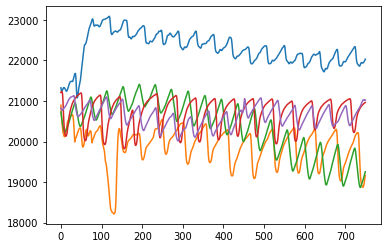

In [11]:
for _ in range(5):
  plt.plot(random.sample(signals,1)[0])

## Normalize

[ 16   1   0   3  11  21  30  38  45  52  60  68  77  86  94 102 109 116
 123 129 134 139 144 149 154 159 163 168 172 176 181 185 189 191 191 182
 168 153 131 104  85  74  64  56  52  51  56  64  73  82  90  96 103 110
 116 123 130 137 143 148 154 159 163 168 172 176 180 184 188 191 194 198
 201 205 208 211 214 214 207 193 178 158 131 112 101  93  86  81  81  86
  94 103 111 117 122 127 134 140 145 152 158 164 169 174 178 181 185 189
 192 196 199 202 205 208 211 214 217 219 218 209 194 178 154 126 107  95
  85  77  72  70  73  79  88  97 106 113 119 126 132 139 144 151 157 162
 168 173 178 183 186 190 194 197 200 204 208 211 215 217 220 223 224 218
 204 187 165 136 114 101  88  78  72  68  70  75  84  94 103 110 116 123
 130 137 144 150 157 162 168 173 178 182 187 191 194 198 201 205 208 212
 215 218 222 225 228 230 232 230 220 204 186 161 133 115 103  94  85  80
  79  82  90 101 110 117 124 131 137 144 150 156 161 167 172 177 181 186
 190 194 198 201 205 208 212 215 218 221 225 228 23

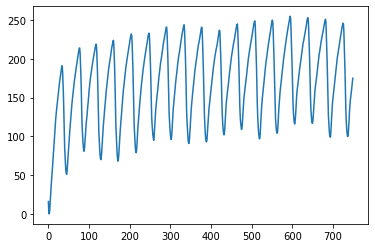

In [12]:
signal_length = len(signals[0])

normalized = [minmax_scale(signal, feature_range=(0,255)).astype('uint8')[:signal_length] for signal in signals]

signal = random.sample(normalized,1)[0]
print(signal)
plt.plot(signal)

# Signal To Image
Lightly dataloads can only load images, so we convert our 1D signals into 1D greyscale images.

## Generation

(672, 672)


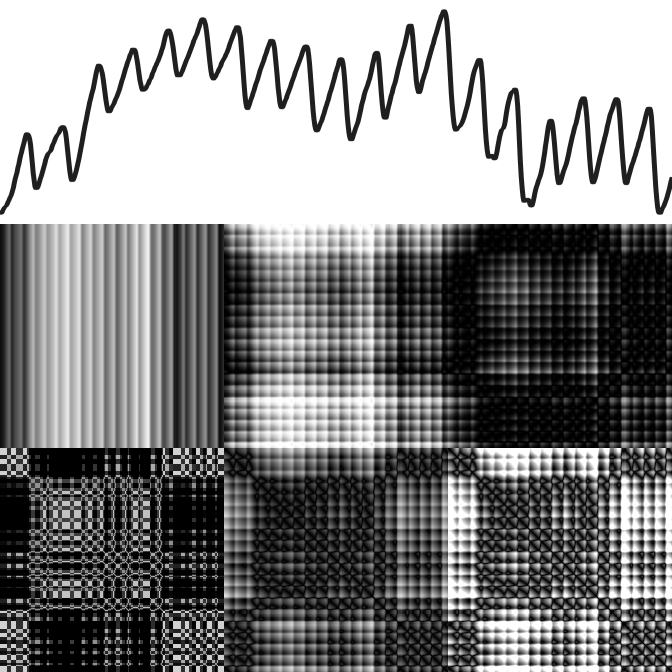

In [13]:
def signal_to_image(signal):

  signal = minmax_scale(signal, feature_range = (-0.9,+0.9))

  subimage_size = 224
  total_width = subimage_size * 3
  total_height = total_width
  colormap = 'gray'
  signal_to_image_transforms = [
      TSToPlot(size=total_width, lw=5),
      TSToMat (size=subimage_size,cmap=colormap),
      TSToGADF(size=subimage_size,cmap=colormap),
      TSToGASF(size=subimage_size,cmap=colormap),
      TSToMTF (size=subimage_size,cmap=colormap),
      TSToRP  (size=subimage_size,cmap=colormap),
      TSToJRP (size=subimage_size,cmap=colormap)]
  
  transformeds = []
  for transform in signal_to_image_transforms:
    tensor = TSTensor(np.expand_dims(np.expand_dims(signal,0),0))
    tensor.to('cpu')
    transformed = np.moveaxis(np.squeeze(transform(tensor).numpy()),0,2)
    transformeds.append(transformed[...,0])

  stacked_image = np.zeros((total_height, total_width), dtype='float')
  plot_image = transformeds[0]
  stacked_image[:subimage_size, :] = resize(plot_image, (subimage_size, total_width),  anti_aliasing=True)
  index = 1
  for row in range(1,3):
    for col in range(0,3):
      stacked_image[row*subimage_size:(row+1)*subimage_size,
                    col*subimage_size:(col+1)*subimage_size] = transformeds[index]
      index += 1
  stacked_image = np.stack((stacked_image,)*3, axis=-1) # https://stackoverflow.com/a/40119878
  stacked_image = Image.fromarray(np.uint8(stacked_image*255))
  return stacked_image

signal = random.sample(normalized,1)[0]
image = signal_to_image(signal)
print(image.shape)
display(image)

## Saving

In [14]:
image_dir = '1d_images' #os.path.join(data_dir, '1d_images')
if os.path.isdir(image_dir):
  rmtree(image_dir)
os.mkdir(image_dir)

for i, signal in enumerate(normalized):
  img = signal_to_image(signal)
  img.save(os.path.join(image_dir, f'{i}.png'))
  print(i, '/', len(signals))

0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100


# Augmentations

num_to_visualize = 4 (out of a possible 100)


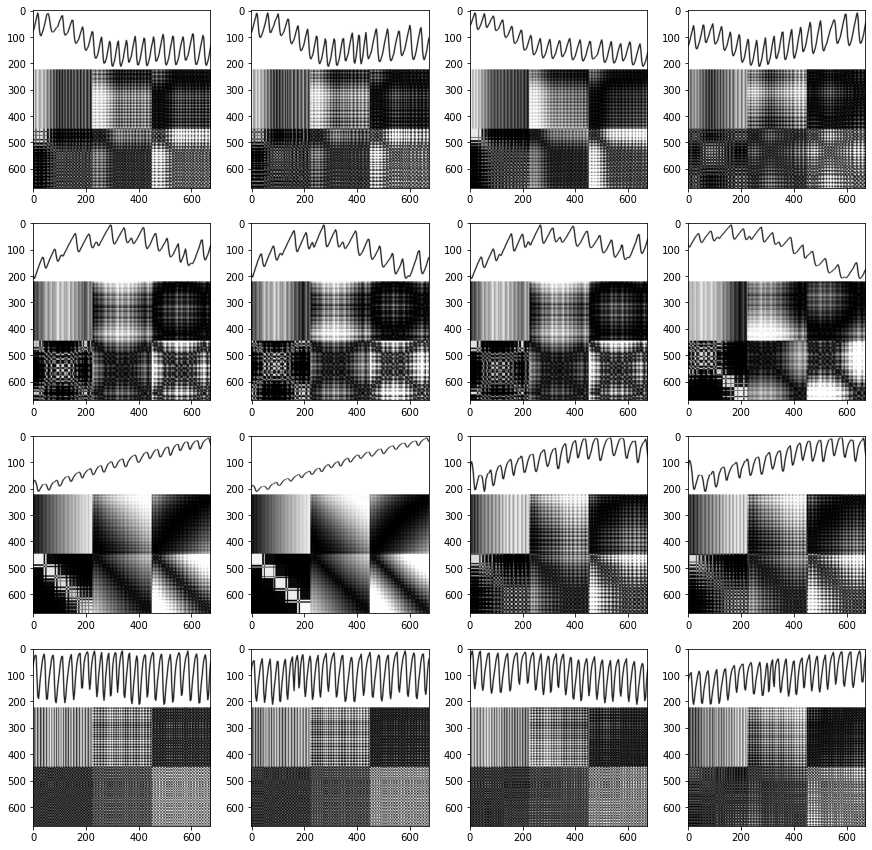

In [15]:
tsai_augmenters = [
    TSTimeWarp(augmentation_magnitude/8),
    TSWindowWarp(augmentation_magnitude/8),
    TSRandomTrend(augmentation_magnitude),
    TSMagScale(augmentation_magnitude),
]

def apply_augmenter(augmenter, numpy_signal):
  signal = np.expand_dims(np.expand_dims(numpy_signal,0),0)
  signal = TSTensor(signal)
  signal.to('cpu')
  return np.squeeze(augmenter.encodes(signal).numpy())

temp_signal = []

class OneDimensionalAugmenter:
  def __call__(self, image: torch.Tensor) -> torch.Tensor:

    middle_row = image.shape[1]//2 # where the raw signal is as a greyscale subsection of the image
    third_width = image.shape[2]//3 # covers a third of the image, horizontally
    signal = image[0,middle_row,:third_width].numpy()

    #old_mean = signal.mean()
    for augmenter in tsai_augmenters:
      signal = apply_augmenter(augmenter, signal)
    #new_mean = signal.mean()
    #print(f'Augmented. old mean = {old_mean}, new mean = {new_mean}')

    output = image.clone()
    augmented_image = np.array(signal_to_image(signal))
    augmented_image = np.moveaxis(augmented_image, 2, 0)
    output[:,:,:] = Tensor(augmented_image/255.)
    return output
  
transform = Compose([
    ToTensor(),
    OneDimensionalAugmenter(),
])
collate_fn = lightly.data.BaseCollateFunction(transform)



num_to_visualize = 4
num_augmentations = 4

files = glob.glob(image_dir + '/*.png')
files_batch = random.choices(files, k=num_to_visualize)
print(f'num_to_visualize = {num_to_visualize} (out of a possible {len(files)})')
images = [Image.open(f).convert('RGB') for f in files_batch]


def apply_augmentations(image, transform):
  if isinstance(transform, Compose):
    for transform_ in transform.transforms:
      image = apply_augmentations(image, transform_)
  else:
    image = transform(image)
  return image

augmenteds = []
for image in images:
  augmenteds.append([apply_augmentations(image, collate_fn.transform).numpy() for _ in range(num_augmentations)])

f, axarr = plt.subplots(len(images),num_augmentations, figsize=(15, 15))

for r, current_augmentations in enumerate(augmenteds):
  for c, augmentation in enumerate(current_augmentations):
    axarr[r,c].imshow(np.array(np.moveaxis(augmentation,0,2)))

## Caching Augmentations

In [16]:
import os
from glob import glob
augmentation_dir = 'augmentations' #os.path.join(data_dir, '1d_images')
num_augmentations = 10
if os.path.isdir(augmentation_dir):
  rmtree(augmentation_dir)
os.mkdir(augmentation_dir)

all_images = glob(image_dir + '/*.png')

for index,image_filename in enumerate(all_images):
  print(index, '/', len(all_images))
  image_folder = os.path.join(augmentation_dir,image_filename.split('/')[-1].replace('.png',''))
  os.mkdir(image_folder)
  image = Image.open(image_filename)
  for i in range(num_augmentations):
    image = apply_augmentations(image, collate_fn.transform).numpy()
    image = Image.fromarray(np.array(np.moveaxis(image*255,0,2)).astype(np.uint8))
    image.save(os.path.join(image_folder,str(i)+'.png'))

0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100


# Cached Augmentations

In [17]:
class CachedAugmenter:
  def __init__(self,pre_saved_file_path:str = "augmentations"):
    self.pre_saved_file_path = pre_saved_file_path

  def __call__(self,image_filename:str):
    image_filename = image_filename.split('/')[-1].replace('.png','')
    augmented_images = glob.glob(os.path.join(self.pre_saved_file_path,image_filename)+"/*")
    augmented_image = random.sample(augmented_images,1)[0]
    im = Image.open(augmented_image)
    return im

# alternative to default loader to return filenames insted of PIL image
def filename_loader(f):
    return f
                        

transform = Compose([
    CachedAugmenter(),
    ToTensor()
])
collate_fn = lightly.data.BaseCollateFunction(transform)



# Training

In [18]:
class SimSiam(nn.Module):
    def __init__(
        self, backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim
    ):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamPredictionHead(
            num_ftrs, proj_hidden_dim, out_dim
        )
        self.prediction_head = SimSiamPredictionHead(
            out_dim, pred_hidden_dim, out_dim
        )

    def forward(self, x):
        # get representations
        f = self.backbone(x).flatten(start_dim=1)
        # get projections
        z = self.projection_head(f)
        # get predictions
        p = self.prediction_head(z)
        # stop gradient
        z = z.detach()
        return z, p

resnet = resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])

model = SimSiam(backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(device)

dataset_train = lightly.data.LightlyDataset(
    input_dir=image_dir
)

dataset_train.dataset.loader = filename_loader

data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=1
)

cuda


In [19]:
import os
import glob
avg_loss = 0.
avg_output_std = 0.
total_backprops = 0
max_backprops = epochs * max_batches_per_epoch * batch_size

from time import monotonic
from datetime import datetime, timedelta

# SimSiam uses a symmetric negative cosine similarity loss
criterion = lightly.loss.NegativeCosineSimilarity()

# scale the learning rate
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=5e-4
)

start_time = monotonic()


for e in range(epochs):

    print(f'\nEpoch {e+1} of {epochs} starting...')
    for b, ((x0, x1), _, _) in enumerate(data_loader):

        if b >= max_batches_per_epoch: break

        elapsed_seconds = monotonic()-start_time
        seconds_per_backprop = elapsed_seconds/(total_backprops+1e-6)
        backprops_remaining = max_backprops-total_backprops
        seconds_remaining = backprops_remaining * seconds_per_backprop
        time_remaining = timedelta(seconds=seconds_remaining)

        print('')
        print(f'{total_backprops}/{max_backprops} backpropagations completed ({total_backprops*1000//max_backprops/10}% done training)')
        print(f'elapsed_seconds = {round(elapsed_seconds)}')
        print(f'backprops_remaining = {backprops_remaining}')
        print(f'\n~~~~~\ntime_remaining = {time_remaining}\n~~~~\n')
        print(f'\n{b*batch_size}/{len(normalized)} ({b*batch_size*1000//len(normalized)/10}%) selfies backpropagated this epoch')
        print(f'batch_size = {batch_size}')
        print(f'Epoch {e+1}/{epochs}, Batch {b+1}/{max_batches_per_epoch} starting...')

        # move images to the gpu
        x0 = x0.to(device)
        x1 = x1.to(device)

        # run the model on both transforms of the images
        # we get projections (z0 and z1) and
        # predictions (p0 and p1) as output
        z0, p0 = model(x0)
        z1, p1 = model(x1)

        # apply the symmetric negative cosine similarity
        # and run backpropagation
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output = p0.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

        # the level of collapse is large if the standard deviation of the l2
        # normalized output is much smaller than 1 / sqrt(dim)
        collapse_level = max(0., 1 - math.sqrt(out_dim) * avg_output_std)

        # print intermediate results
        print(f'Loss = {avg_loss:.2f} | '
              f'Collapse Level: {collapse_level:.2f}')
        total_backprops += batch_size
        
    print(f'\nEpoch {e+1} ended.')

print(f'\n\nTraining completed at {datetime.now()} GMT+0')


Epoch 1 of 10 starting...

0/800 backpropagations completed (0.0% done training)
elapsed_seconds = 1
backprops_remaining = 800

~~~~~
time_remaining = 11764 days, 5:23:56.800037
~~~~


0/100 (0.0%) selfies backpropagated this epoch
batch_size = 16
Epoch 1/10, Batch 1/5 starting...
Loss = -0.00 | Collapse Level: 0.92

16/800 backpropagations completed (2.0% done training)
elapsed_seconds = 9
backprops_remaining = 784

~~~~~
time_remaining = 0:07:20.424030
~~~~


16/100 (16.0%) selfies backpropagated this epoch
batch_size = 16
Epoch 1/10, Batch 2/5 starting...
Loss = -0.01 | Collapse Level: 0.85

32/800 backpropagations completed (4.0% done training)
elapsed_seconds = 10
backprops_remaining = 768

~~~~~
time_remaining = 0:03:54.213087
~~~~


32/100 (32.0%) selfies backpropagated this epoch
batch_size = 16
Epoch 1/10, Batch 3/5 starting...
Loss = -0.01 | Collapse Level: 0.78

48/800 backpropagations completed (6.0% done training)
elapsed_seconds = 11
backprops_remaining = 752

~~~~~
time

# Visualize Output

## Embed

In [20]:
def embed_random_signals(num_to_embed):
  print(f'num_to_embed = {num_to_embed}')
  embeddings = []
  embedded_filenames = []

  max_embedding_batches = (num_to_embed+batch_size-1)//batch_size

  # disable gradients for faster calculations
  model.eval()
  with torch.no_grad():
      for b, ((x, _), _, fnames) in enumerate(data_loader):

          if b >= max_embedding_batches: break
          
          print(f'\nEmbedding batch {b+1}/{max_embedding_batches}...')

          # move the images to the gpu
          print(type(x))
          print(len(x))

          print(f'x.shape = {x.shape}')
          x = x.to(device)
          
          # embed the images with the pre-trained backbone
          print('Calculating embeddings...')
          y = model.backbone(x)
          print('Calculated.')
          print(f'y.shape = {y.shape}')
          y = y.flatten(start_dim=1)
          print(f'y.shape = {y.shape}')

          # store the embeddings and filenames in lists
          embeddings.append(y)
          embedded_filenames = embedded_filenames + list(fnames)

          print(f'Embedded {len(embedded_filenames)}/{max_embedding_batches*batch_size} ({len(embedded_filenames)*1000//(max_embedding_batches*batch_size)/10}%).')

  # concatenate the embeddings and convert to numpy
  embeddings = torch.cat(embeddings, dim=0)
  embeddings = embeddings.cpu().numpy()

  print('\nEmbeddings done.')
  print(f'type(embeddings) = {type(embeddings)}')
  print(f'embeddings.shape = {embeddings.shape}')

  embeddings = embeddings[:num_to_embed,:]
  print(f'embeddings.shape = {embeddings.shape}')

  return embeddings, embedded_filenames


projection_embeddings, projection_filenames = embed_random_signals(plotting_N)
print(len(projection_filenames))
print(projection_embeddings.shape)

num_to_embed = 800

Embedding batch 1/50...
<class 'torch.Tensor'>
16
x.shape = torch.Size([16, 3, 672, 672])
Calculating embeddings...
Calculated.
y.shape = torch.Size([16, 512, 1, 1])
y.shape = torch.Size([16, 512])
Embedded 16/800 (2.0%).

Embedding batch 2/50...
<class 'torch.Tensor'>
16
x.shape = torch.Size([16, 3, 672, 672])
Calculating embeddings...
Calculated.
y.shape = torch.Size([16, 512, 1, 1])
y.shape = torch.Size([16, 512])
Embedded 32/800 (4.0%).

Embedding batch 3/50...
<class 'torch.Tensor'>
16
x.shape = torch.Size([16, 3, 672, 672])
Calculating embeddings...
Calculated.
y.shape = torch.Size([16, 512, 1, 1])
y.shape = torch.Size([16, 512])
Embedded 48/800 (6.0%).

Embedding batch 4/50...
<class 'torch.Tensor'>
16
x.shape = torch.Size([16, 3, 672, 672])
Calculating embeddings...
Calculated.
y.shape = torch.Size([16, 512, 1, 1])
y.shape = torch.Size([16, 512])
Embedded 64/800 (8.0%).

Embedding batch 5/50...
<class 'torch.Tensor'>
16
x.shape = torch.Size([16, 3, 672, 672]

In [21]:
print(len(projection_filenames))
print(projection_embeddings.shape)

96
(96, 512)


## Generate Thumbnails

In [22]:
thumbnails = {}
for i, filename in enumerate(projection_filenames):
  print(i, '/', len(projection_filenames), filename)

  try:
    index = eval(filename[:-4])
    signal = normalized[index]
    image = signal_to_image(signal).resize((thumbnail_size,thumbnail_size))
    thumbnails[filename] = image
  except BaseException:
    print('Error')


0 / 96 43.png
1 / 96 71.png
2 / 96 6.png
3 / 96 23.png
4 / 96 93.png
5 / 96 38.png
6 / 96 22.png
7 / 96 28.png
8 / 96 96.png
9 / 96 34.png
10 / 96 79.png
11 / 96 81.png
12 / 96 99.png
13 / 96 0.png
14 / 96 90.png
15 / 96 26.png
16 / 96 29.png
17 / 96 60.png
18 / 96 54.png
19 / 96 97.png
20 / 96 41.png
21 / 96 27.png
22 / 96 49.png
23 / 96 7.png
24 / 96 73.png
25 / 96 8.png
26 / 96 13.png
27 / 96 53.png
28 / 96 37.png
29 / 96 4.png
30 / 96 87.png
31 / 96 25.png
32 / 96 66.png
33 / 96 72.png
34 / 96 24.png
35 / 96 69.png
36 / 96 1.png
37 / 96 98.png
38 / 96 30.png
39 / 96 59.png
40 / 96 57.png
41 / 96 80.png
42 / 96 76.png
43 / 96 89.png
44 / 96 18.png
45 / 96 55.png
46 / 96 84.png
47 / 96 45.png
48 / 96 95.png
49 / 96 32.png
50 / 96 85.png
51 / 96 14.png
52 / 96 86.png
53 / 96 94.png
54 / 96 15.png
55 / 96 17.png
56 / 96 35.png
57 / 96 47.png
58 / 96 70.png
59 / 96 77.png
60 / 96 52.png
61 / 96 78.png
62 / 96 58.png
63 / 96 40.png
64 / 96 42.png
65 / 96 67.png
66 / 96 64.png
67 / 96 74.

## Reduce Dimensions

In [23]:
projections = pacmap.PaCMAP(n_components=2).fit_transform(projection_embeddings)
projections = minmax_scale(projections)
print(f'projection_embeddings.shape = {projection_embeddings.shape}')
print(f'\nprojected shape = {projections.shape}')

projection_embeddings.shape = (96, 512)

projected shape = (96, 2)


## Circlize

In [24]:
def rotate(projection, *, degrees):
  theta = np.deg2rad(degrees)
  rotation_matrix = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
  return np.dot(projection, rotation_matrix.T)

def circlize(projection, *, full_rotations=10, degrees_step=17):

  preprocessors = {}

  for degrees in range(0, 360 * full_rotations, degrees_step):

    projection = rotate(projection, degrees=degrees)
    print(f'\nRotated points {degrees}°')

    normalizer = QuantileTransformer(n_quantiles=100)
    normalizer.fit(projection)

    projection = normalizer.transform(projection)
    print('Quantiles normalized.')

    preprocessors[degrees] = normalizer

  print(f'\npreprocessors = {preprocessors}')
  return preprocessors, projection

_, circlized = circlize(projections, full_rotations=circlize_rotations, degrees_step=circlize_degrees)



Rotated points 0°
Quantiles normalized.

Rotated points 237°
Quantiles normalized.

Rotated points 474°
Quantiles normalized.

Rotated points 711°
Quantiles normalized.

preprocessors = {0: QuantileTransformer(n_quantiles=100), 237: QuantileTransformer(n_quantiles=100), 474: QuantileTransformer(n_quantiles=100), 711: QuantileTransformer(n_quantiles=100)}


## Plot

96
96
100


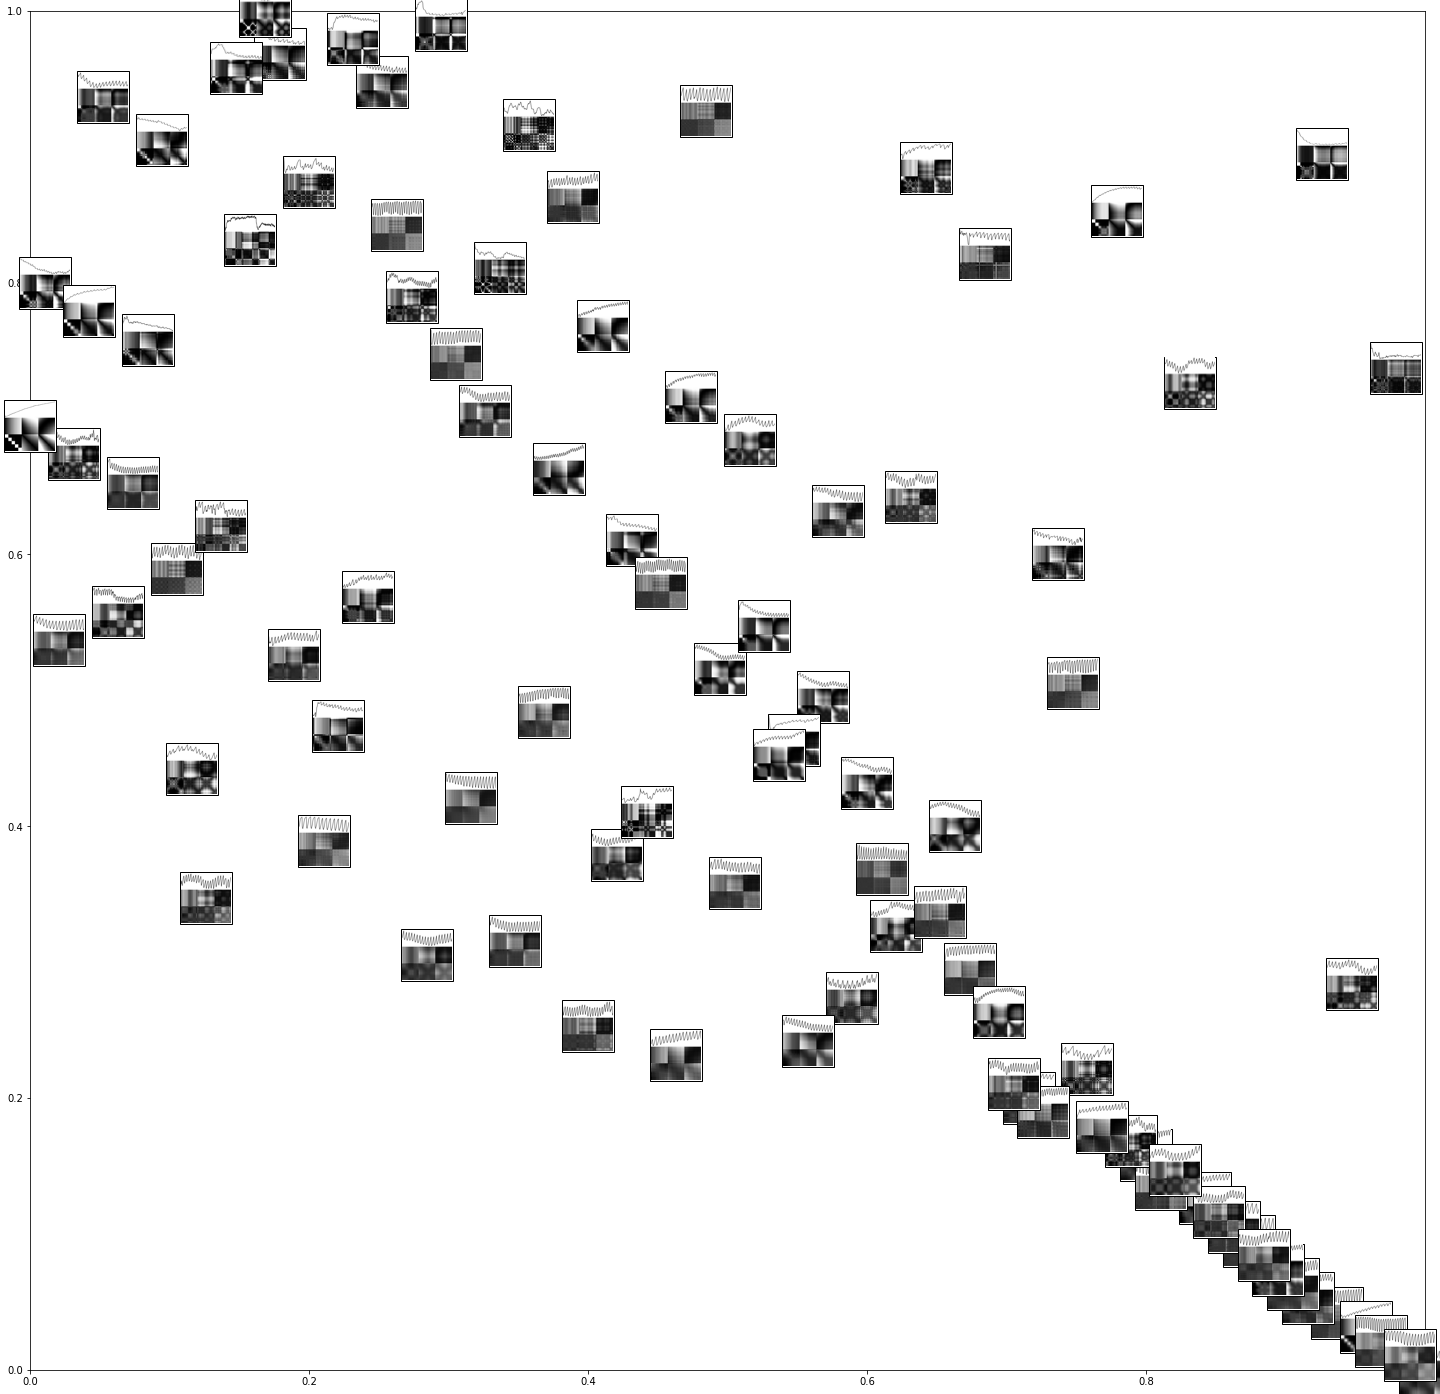

In [25]:
fig = plt.figure(figsize=(output_fig_size,output_fig_size))
ax = fig.add_subplot(1, 1, 1)

print(len(projections))
print(len(projection_filenames))
print(len(normalized))

for projection, filename in zip(circlized, projection_filenames):
  try:
    image = np.array(thumbnails[filename])
    img_box = osb.AnnotationBbox(
        osb.OffsetImage(image, cmap=plt.cm.gray_r),
        projection,
        pad=0.1,
    )
    ax.add_artist(img_box)
  except BaseException:
    pass